**Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.**

In [1]:
from keras.applications import VGG16
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

In [3]:
# Combining the VGG16 convolutional layer and ours dense layer

from keras import models
from keras.layers import Dense, Dropout, Flatten

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [4]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [5]:
conv_base.trainable = False

In [6]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

base_dir =  r"C:\Users\rakes\Desktop\Rakesh\Deep Learning\Deep Learning with Python - Francois Chollet\Ch-5\cats_dogs_small"
train_dir = os.path.join(base_dir,'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')


train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                  fill_mode='nearest',horizontal_flip=True, vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), 
                                                    batch_size=32, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(150,150), batch_size=32,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [9]:
history = model.fit_generator(train_generator, steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=1)

Epoch 1/30
100/100 [==============================] - 502s 5s/step - loss: 0.6916 - acc: 0.5912 - val_loss: 0.5284 - val_acc: 0.7703
Epoch 2/30
100/100 [==============================] - 496s 5s/step - loss: 0.6135 - acc: 0.6558 - val_loss: 0.4524 - val_acc: 0.8106
Epoch 3/30
100/100 [==============================] - 513s 5s/step - loss: 0.5558 - acc: 0.7203 - val_loss: 0.4230 - val_acc: 0.8242
Epoch 4/30
100/100 [==============================] - 498s 5s/step - loss: 0.5295 - acc: 0.7327 - val_loss: 0.3162 - val_acc: 0.8415
Epoch 5/30
100/100 [==============================] - 441s 4s/step - loss: 0.5090 - acc: 0.7519 - val_loss: 0.3838 - val_acc: 0.8357
Epoch 6/30
100/100 [==============================] - 300s 3s/step - loss: 0.4823 - acc: 0.7657 - val_loss: 0.3191 - val_acc: 0.8415
Epoch 7/30
100/100 [==============================] - 295s 3s/step - loss: 0.4833 - acc: 0.7652 - val_loss: 0.2320 - val_acc: 0.8363
Epoch 8/30
100/100 [==============================] - 295s 3s/step - 

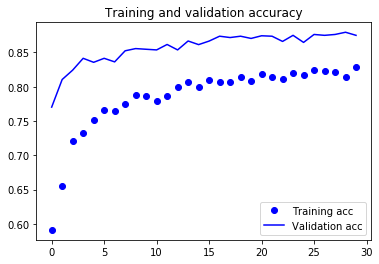

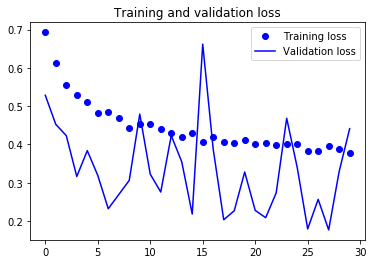

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine Tuning

In [8]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 335s 3s/step - loss: 0.6766 - acc: 0.5896 - val_loss: 0.4730 - val_acc: 0.8084
Epoch 2/100
  5/100 [>.............................] - ETA: 3:53 - loss: 0.5779 - acc: 0.6625